<a href="https://www.kaggle.com/code/lazuardialmuzaki/sentiment-analysis-spotify-app-store-review?scriptVersionId=142565086" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Sentiment Analysis: Spotify App Store Review

In [1]:
#importing selected various python libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import PlaintextCorpusReader
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import nltk
nltk.download('punkt')
nltk.download('omw-1.4')
import warnings
warnings.filterwarnings('ignore')

from wordcloud import WordCloud
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.text import Text
from nltk.probability import FreqDist
from nltk.tag import pos_tag
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Importing and Examining Raw Data

In [2]:
music_review = pd.read_csv('/kaggle/input/spotify-app-review/reviews.csv') # read the csv file that is a collection of Spotify App Review since January 2022 to July 2022 

In [3]:
#checking the dataframe of uploaded data
music_review

,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN
...,...,...,...,...,...
61589,2022-01-01 03:01:29,Even though it was communicated that lyrics fe...,1,6,NaN
61590,2022-01-01 02:13:40,"Use to be sooo good back when I had it, and wh...",1,0,NaN
61591,2022-01-01 01:02:29,This app would be good if not for it taking ov...,2,10,NaN
61592,2022-01-01 00:49:23,The app is good hard to navigate and won't jus...,2,1,NaN


We have review as main column here and several others columns. Here goes the definition:

- Time_submitted: Describe when did the review's written
- Review: The app's user review from each of users
- Rating: Numerical representation on how the user liking the app (scale of 1-5)
- Total_thumbsup: Count how many other users find a specific review useful
- Reply: Return a reply that a review might be getting

As we have called the DataFrame above, we knew that we have 61,594 data of user reviews

In [4]:
music_review.isna().sum()

Time_submitted        0
Review                0
Rating                0
Total_thumbsup        0
Reply             61378
dtype: int64

We checked that for the main column of Review there's no column with N/A value. Eventhough we found that 'Reply' column have almost all of rows being N/A, we don't think it's necessary to drop any of the data row as 'Reply' column is not going to be our focus here.

In [5]:
music_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61594 entries, 0 to 61593
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Time_submitted  61594 non-null  object
 1   Review          61594 non-null  object
 2   Rating          61594 non-null  int64 
 3   Total_thumbsup  61594 non-null  int64 
 4   Reply           216 non-null    object
dtypes: int64(2), object(3)
memory usage: 2.3+ MB


## Data Pre-processing and Text Tokenizing

### Data Pre-processing

Data Pre-processing here is one process of data preparation before we could begin the text mining process. 
We create a new column named 'Rating Category' that converts numerical rating data into ordinal data.
So in that way, we could get clarity which review is actually considered to be bad review and so on.


In [6]:
# defining rule to determine whether a review is bad, average or good based on the numerical rating

def rating_def(x):
  if x== 4 or x== 5:
    return 'Good'
  elif x== 3:
    return 'Average'
  else:
    return 'Bad'

In [7]:
# initializing 'rating category' column to all of row
music_review['Rating_Category'] = music_review['Rating'].apply(lambda x: rating_def(x))

In [8]:
# defining formula to plot histogram using seaborn package

def plot_histogram(data_f,xvalue,category):
  sns.displot(data = data_f, x = xvalue,kind = 'hist',color = '#800080',hue=category)

In [9]:
def remove_stopwords(additionalList,falseList):
    
    stopwordList = []
    stopwordList = stopwords.words('english')
    stopwordList = stopwordList + additionalList
    stopwordnewList = []
    for x in falseList:
        for y in stopwordList:
            if x != y :
                stopwordnewList.append(y)
    return stopwordnewList
        

In [10]:
def plot_words(title,type_word):
    #plt.subplot(1,2,1)
    plt.title(title)
    type_word.plot(20)

In [11]:
def plot_wordcloud(token_type):
    cloud = WordCloud(width=800, height=400, max_font_size=160,colormap="Set1").generate(' '.join(token_type))
    #plt.subplot(1,2,1)
    plt.rcParams["figure.figsize"] = (16,12)
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [12]:
def word_type(types):
    word_type = [word for (word, pos) in tokens if (pos in [types]) & (word not in stopwordnew)] 
    word_type[:20]
    fdist = FreqDist(word_type)
    return fdist.most_common(20)

In [13]:
def top_n_ngram(corpus,n = None,ngram = 1, words_stop = stopwords.words('english')):
    vec = CountVectorizer(stop_words = words_stop,ngram_range=(ngram,ngram)).fit(corpus)
    bag_of_words = vec.transform(corpus) #Have the count of  all the words for each review
    sum_words = bag_of_words.sum(axis =0) #Calculates the count of all the word in the whole review
    words_freq = [(word,sum_words[0,idx]) for word,idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq,key = lambda x:x[1],reverse = True)
    return words_freq[:n]

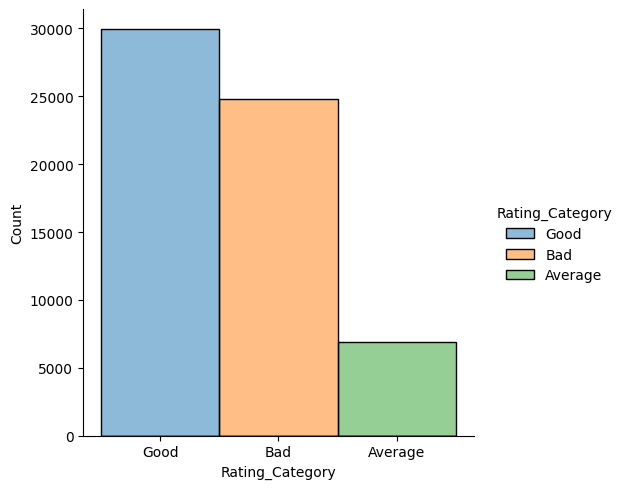

In [14]:
plot_histogram(music_review,music_review['Rating_Category'], 'Rating_Category')

From histogram above, we could see that majority of reviews from approximately 61 thousand users find Spotify being satisfactory with around 30 thousand of them rated it good. On the other hand, we still have significant proportion of users still having bad experiences with the app as they rated it low. This finding needs to be elaborated using text mining 

### Text Tokenizing

Another way to actually prepare our data is through text tokenizing.
Text mining works best when we tokenize our data first before being treated. In that regards, we want to tokenize every word for every review we have.

Code below will perform lowercasing action throughout entire words on Review column, so we wouldn't confuse same exact words treated as different tokens as it is case-sensitive. 

In [15]:
music_review['Review'] = music_review['Review'].astype(str).str.lower()


In [16]:
regexp = RegexpTokenizer('\w+')

music_review['review_token']=music_review['Review'].apply(regexp.tokenize)
music_review.head()

,Time_submitted,Review,Rating,Total_thumbsup,Reply,Rating_Category,review_token
0,2022-07-09 15:00:00,"great music service, the audio is high quality...",5,2,NaN,Good,"[great, music, service, the, audio, is, high, ..."
1,2022-07-09 14:21:22,please ignore previous negative rating. this a...,5,1,NaN,Good,"[please, ignore, previous, negative, rating, t..."
2,2022-07-09 13:27:32,"this pop-up ""get the best spotify experience o...",4,0,NaN,Good,"[this, pop, up, get, the, best, spotify, exper..."
3,2022-07-09 13:26:45,really buggy and terrible to use as of recently,1,1,NaN,Bad,"[really, buggy, and, terrible, to, use, as, of..."
4,2022-07-09 13:20:49,dear spotify why do i get songs that i didn't ...,1,1,NaN,Bad,"[dear, spotify, why, do, i, get, songs, that, ..."


In [17]:
additional_stop = ['want']
false_stop = ["don't", "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

stopwordnew = remove_stopwords(additional_stop,false_stop)

Code above generates the stopwords rule. This set of stopwords is going to help us in erasing some words that don't have significant meaning when they are separated as one word.

After initialized, we perform token filtering that actually erase these words from our review_token 

In [18]:
music_review['review_token'] = music_review['review_token'].apply(lambda x: [item for item in x if item not in stopwordnew])
music_review.head(3)

,Time_submitted,Review,Rating,Total_thumbsup,Reply,Rating_Category,review_token
0,2022-07-09 15:00:00,"great music service, the audio is high quality...",5,2,NaN,Good,"[great, music, service, audio, high, quality, ..."
1,2022-07-09 14:21:22,please ignore previous negative rating. this a...,5,1,NaN,Good,"[please, ignore, previous, negative, rating, a..."
2,2022-07-09 13:27:32,"this pop-up ""get the best spotify experience o...",4,0,NaN,Good,"[pop, get, best, spotify, experience, android,..."


Code below will join all of set of tokens in each row into full strings. We stored it as new column named 'review_string' as it will be needed in further text mining process.

In [19]:
music_review['review_string'] = music_review['review_token'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))

In [20]:
music_review[['Review', 'review_token', 'review_string']].head()

,Review,review_token,review_string
0,"great music service, the audio is high quality...","[great, music, service, audio, high, quality, ...",great music service audio high quality app eas...
1,please ignore previous negative rating. this a...,"[please, ignore, previous, negative, rating, a...",please ignore previous negative rating app sup...
2,"this pop-up ""get the best spotify experience o...","[pop, get, best, spotify, experience, android,...",pop get best spotify experience android annoyi...
3,really buggy and terrible to use as of recently,"[really, buggy, terrible, use, recently]",really buggy terrible use recently
4,dear spotify why do i get songs that i didn't ...,"[dear, spotify, get, songs, put, playlist, shu...",dear spotify get songs put playlist shuffle play


Reminder that what differs 'Review' column and 'review_string' column is that on 'review_string' we have excluded words that are not considered important for later text mining process

## Text Mining

In text mining process, NLTK library package is heavily utilized to gather insight from our big data of tokens which have been prepared before.

**Most Common Words**
Examining most common words that appear within all of reviews usually speak much about how generally your product/service being perceived by users. In order to extract the most common words, we use FreqDist method from NLTK library, but firstly we have to join all rows of 'review_string' becoming one big chunk set of sentences.

In [21]:
all_words = ' '.join([word for word in music_review['review_string']])

In [22]:
tokenized_words = nltk.tokenize.word_tokenize(all_words)

In [23]:
fdist = FreqDist(tokenized_words)
fdist.most_common(30)

[('app', 36088),
 ('music', 25784),
 ('spotify', 19123),
 ('songs', 18406),
 ('song', 14989),
 ('play', 11708),
 ('like', 9843),
 ('listen', 9351),
 ('premium', 9035),
 ('love', 9025),
 ('good', 8811),
 ('ads', 8566),
 ('great', 7366),
 ('playlist', 7192),
 ('even', 7021),
 ('playing', 6428),
 ('use', 6067),
 ('get', 5865),
 ('update', 5405),
 ('really', 5022),
 ('one', 4896),
 ('please', 4885),
 ('fix', 4866),
 ('time', 4771),
 ('best', 4715),
 ('every', 4595),
 ('would', 4007),
 ('phone', 3959),
 ('listening', 3955),
 ('also', 3846)]

**Giving a Part of Speech Tag to All Tokens**

Despite having the most common words extracted already from result above, we might aswell want to label them based on their Part of Speech category and grouped them to find a better clarity and sense of being organized.  

In [24]:
tagged_tokens = nltk.pos_tag(tokenized_words)
tagged_tokens[:20]

[('great', 'JJ'),
 ('music', 'NN'),
 ('service', 'NN'),
 ('audio', 'RB'),
 ('high', 'JJ'),
 ('quality', 'NN'),
 ('app', 'VBP'),
 ('easy', 'JJ'),
 ('use', 'NN'),
 ('also', 'RB'),
 ('quick', 'RB'),
 ('friendly', 'JJ'),
 ('support', 'NN'),
 ('please', 'NN'),
 ('ignore', 'VBP'),
 ('previous', 'JJ'),
 ('negative', 'JJ'),
 ('rating', 'NN'),
 ('app', 'JJ'),
 ('super', 'JJ')]

**Extracting Most Common Words for Adjective and Noun**

As we now have our common words being labeled with POS tag, we want to grouped them into Noun to learn what mostly our users associate the app with, and Adjective to learn how mostly our users impressed by the app.

Adjective Most Common Words

In [25]:
tagged_tokens_adj = [token for (token,label) in tagged_tokens if (label in ['JJ'])]
tagged_tokens_adj[:20]

adjdist = FreqDist(tagged_tokens_adj)
adjdist.most_common(20)

[('app', 9098),
 ('good', 8690),
 ('great', 7366),
 ('premium', 4329),
 ('listen', 4272),
 ('spotify', 4047),
 ('update', 3852),
 ('new', 3578),
 ('many', 3544),
 ('free', 3308),
 ('song', 2861),
 ('easy', 2230),
 ('much', 2219),
 ('able', 1950),
 ('last', 1831),
 ('fix', 1817),
 ('open', 1662),
 ('playlist', 1661),
 ('different', 1562),
 ('nice', 1417)]

Sometimes to understand the context of common words, you could utilize concordance feature to examine how some words gathered within sentences they belong

In [26]:
trial_concordance = Text(tokenized_words)
##print(trial_concordance.concordance(["new"]))

In [27]:
erased_tokens = ['app', 'spotify']

tagged_tokens_noun = [token for (token,label) in tagged_tokens if (label in ['NN']) & (token not in erased_tokens) ]
tagged_tokens_noun[:20]

noundist = FreqDist(tagged_tokens_noun)
noundist.most_common(30)

[('music', 25784),
 ('song', 10742),
 ('play', 7152),
 ('time', 4771),
 ('premium', 4448),
 ('playlist', 4395),
 ('use', 4363),
 ('phone', 3959),
 ('love', 3535),
 ('please', 3026),
 ('way', 2751),
 ('problem', 2579),
 ('work', 2434),
 ('service', 2097),
 ('thing', 1931),
 ('experience', 1910),
 ('account', 1897),
 ('pay', 1852),
 ('version', 1810),
 ('quality', 1752),
 ('something', 1701),
 ('issue', 1692),
 ('everything', 1683),
 ('option', 1621),
 ('fix', 1572),
 ('bar', 1559),
 ('download', 1519),
 ('podcast', 1504),
 ('get', 1489),
 ('subscription', 1486)]

Based on the result, it might be needed to have some common words be erased when they don't have really meaningful. Like for example, word 'Spotify' and 'app' are removed because eventhough they are nouns, they were written only as a way to mention about the app itself rather than to explain or describe what the app is 

**Visualizing common words into line graph**


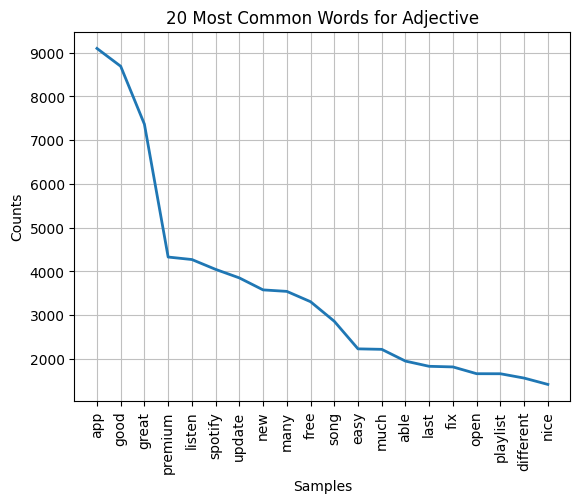

In [28]:
plot_words('20 Most Common Words for Adjective',adjdist )


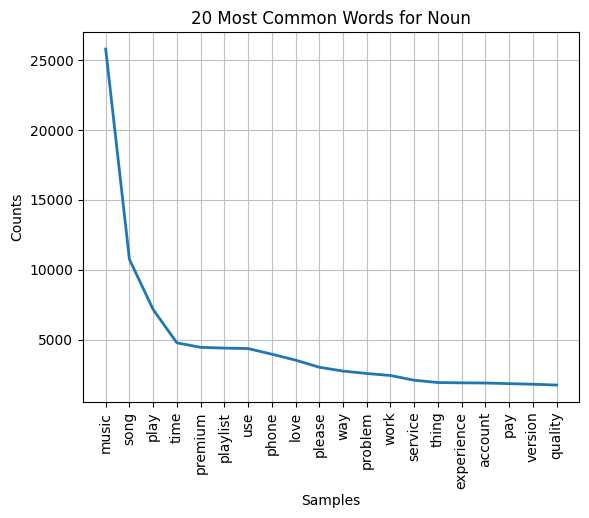

In [29]:
plot_words('20 Most Common Words for Noun',noundist)

**Visualizing most common words in WordCloud**

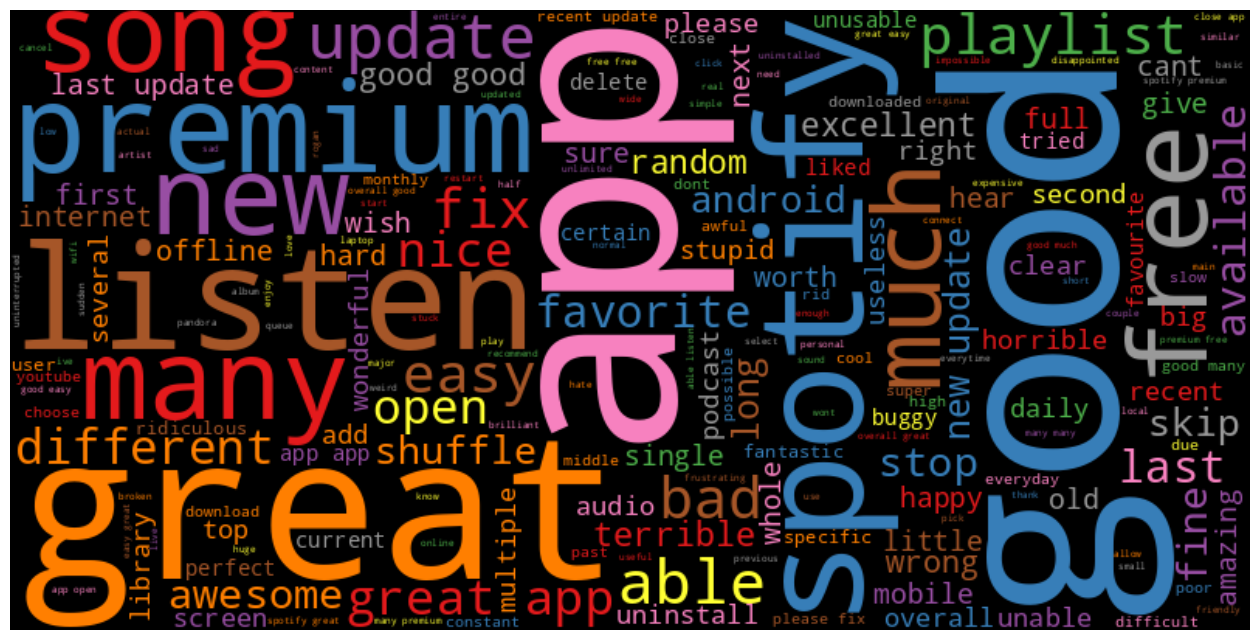

In [30]:
plot_wordcloud(tagged_tokens_adj)

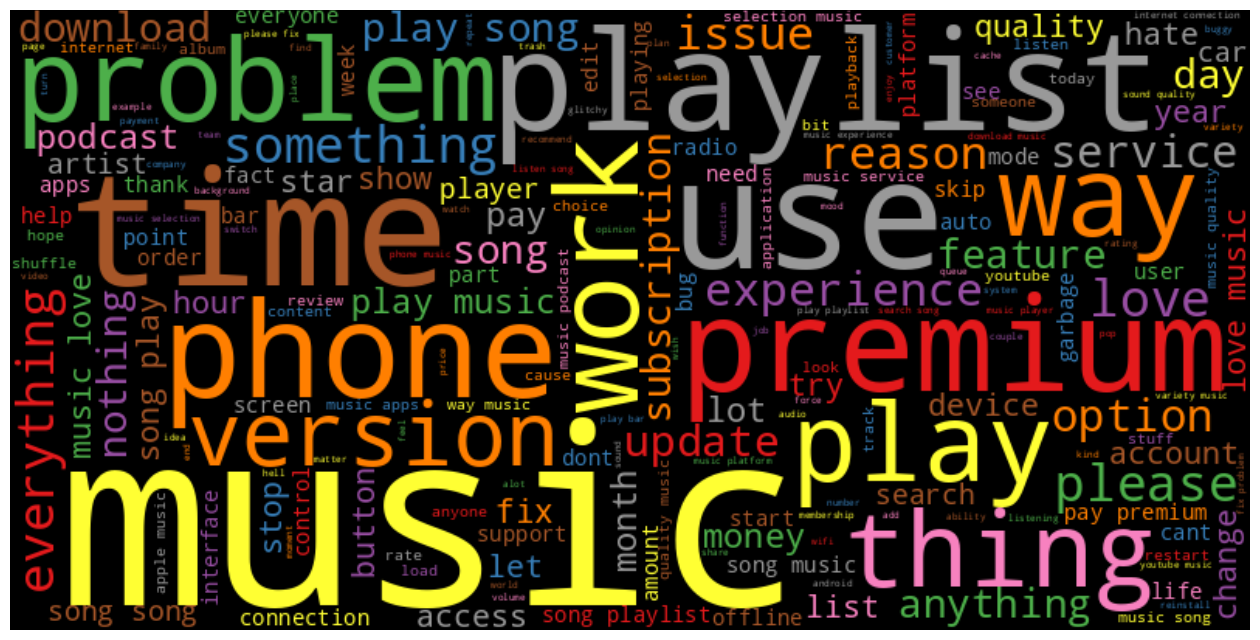

In [31]:
plot_wordcloud(tagged_tokens_noun)

## Working on Negative Reviews

We have learnt about how the app is perceived through examining most common words of adjective and nouns. Most of them are on positive notes. But we remember that we have a relative high number of bad reviews which not yet be adressed.

With that, we ought to work on negative reviews to actually understand what kind of issues or difficulties our users' been encountering.

First of all, we need to re-prepare for DataFrame capturing only bad reviews

In [32]:
bad_reviews = pd.DataFrame(music_review[music_review['Rating_Category']== 'Bad']['Review'])
bad_reviews.head(3)

,Review
3,really buggy and terrible to use as of recently
4,dear spotify why do i get songs that i didn't ...
9,"i'm deleting this app, for the following reaso..."


**Tokenizing and giving POS Tag**

Slightly different from formula above, we want to demonstrate how to perform tokenizing and labeling in one code which goes as follow

In [33]:
tokens = []
for which_row, row in bad_reviews.iterrows():
    tokens = tokens + nltk.pos_tag(word_tokenize(row['Review']))


In [34]:
additional_stop = ['want']
false_stop = ["don't", "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
stopwordnew=[]
stopwordnew = remove_stopwords(additional_stop,false_stop)

In [35]:
bad_adjective = word_type('JJ')
bad_adjective

[('good', 1934),
 ('new', 1678),
 ('many', 1671),
 ('premium', 1605),
 ('free', 1372),
 ('last', 1236),
 ('great', 1120),
 ('app', 1035),
 ('bad', 932),
 ('much', 880),
 ('able', 871),
 ('spotify', 819),
 ('different', 800),
 ('update', 789),
 ('terrible', 600),
 ('random', 595),
 ('recent', 525),
 ('fine', 518),
 ('wrong', 512),
 ('next', 492)]

In [36]:
bad_nouns = word_type('NN')
bad_nouns

[('app', 14523),
 ('song', 8023),
 ('music', 7835),
 ('spotify', 4536),
 ('playlist', 3482),
 ('premium', 2740),
 ('update', 2736),
 ('time', 2640),
 ('phone', 2319),
 ('play', 1642),
 ('account', 1518),
 ('way', 1427),
 ('service', 1126),
 ('problem', 1096),
 ('bar', 1095),
 ('ad', 1088),
 ('issue', 1054),
 ('version', 987),
 ('something', 979),
 ('subscription', 978)]

Looking at how extracting most common words for Bad Adjective and Bad Noun, some findings could be said:

- Some adjective words are actually positive words despite having already filtered the review only for the bad ones
- Having only one word isn't sufficient to explain the issue. For example we found that one of common adjective is 'terrible', but we don't know what actually went terrible

**Initializing N-Gram**

To tackle this issue, we introduced N-Gram in the text mining process that bundles n number of words altogether that are neighbouring tokens. With this we could find improved clarity on context of the issue.

<Axes: title={'center': 'Graph 1: Top 20 trigrams in review after removing stop words'}, ylabel='ReviewText'>

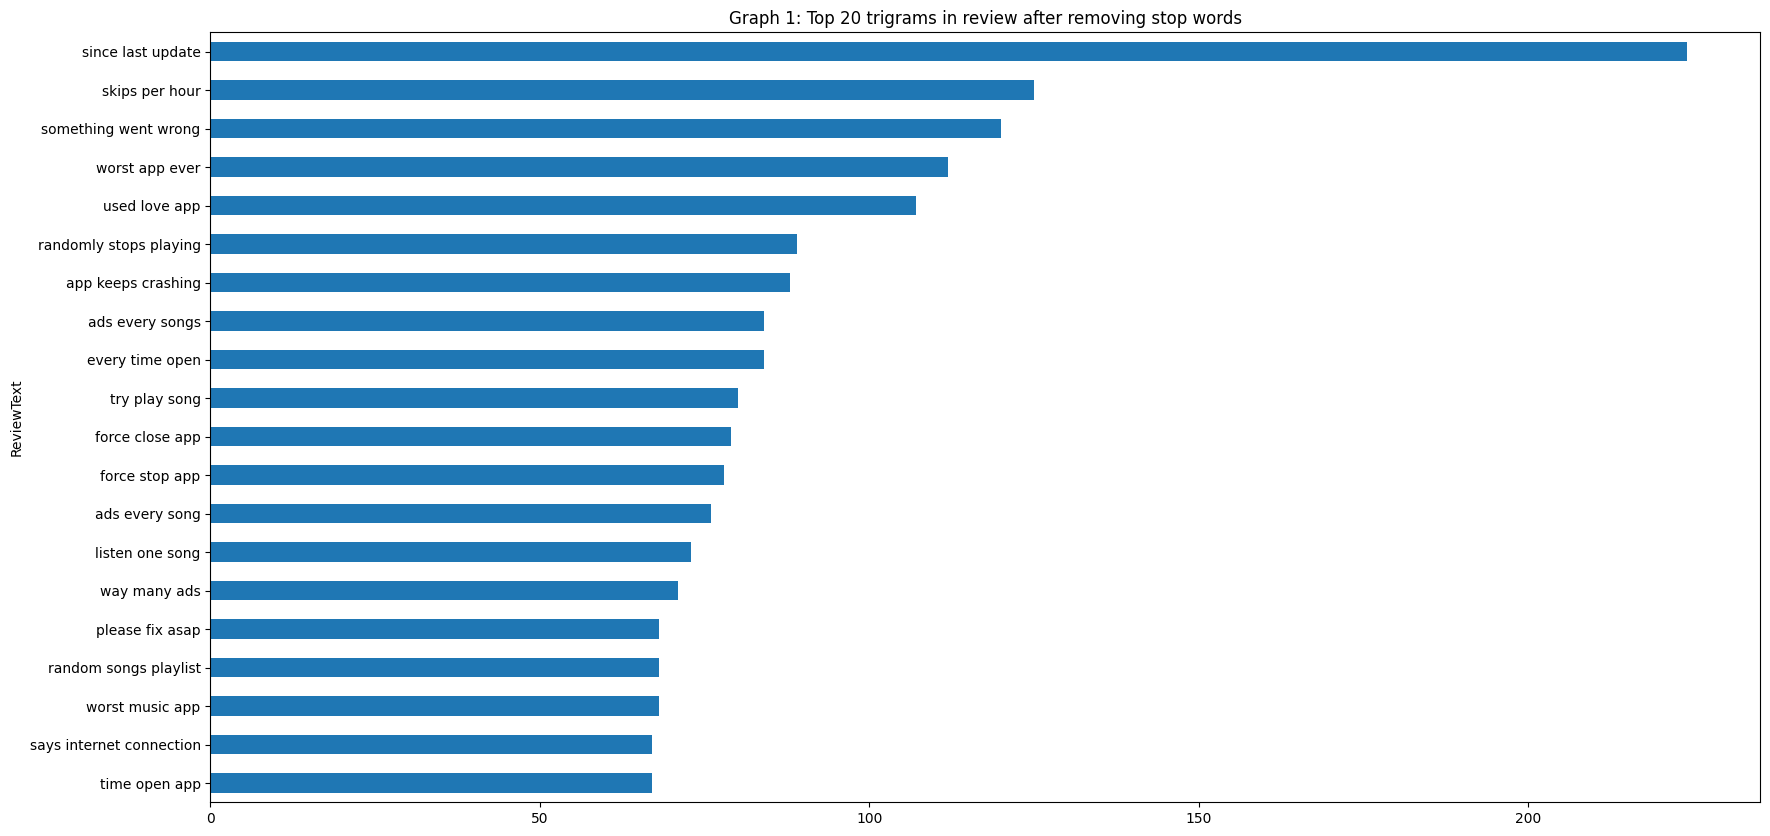

In [37]:
bad_review = pd.DataFrame(music_review[music_review['Rating']<3]['review_string'])

common_words = top_n_ngram(bad_review['review_string'], 20, 3)
df_bad_review = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
plt.style.use('default')
plt.figure(figsize =(20,10))
df_bad_review.groupby('ReviewText').sum()['count'].sort_values(ascending=True).plot(
kind='barh', title='Graph 1: Top 20 trigrams in review after removing stop words')


Using **trigram**, we now have a far better understanding of the issues that mostly addressed in bad reviews.

But notice that we have one trigram that not really explaining a problem yet it appears most of the time which is "since last update". Reading this, we sense that several mentioned issue might be appeared after Spotify made some updates of the app. With this finding, we want to go deep-dive into what is the specific issues people felt and found after the app being updated  

We can use concordance again to confirm our guess regarding the context of 'since last update' trigram

In [38]:
trial_concordance = Text(tokenized_words)
##print(trial_concordance.concordance(["since", "last", 'update']))

**Creating designated DataFrame through slicing the main DataFrame**

Because now we want to focus on working with 'Since last update' issues on reviews, we need to prepare a designated DataFrame to work on. We will slice the main DataFrame of music_review by only filter ones which review containing token words of 'since', 'last', and 'update'. In that way, we could get better grasp on what do people talk about when they talk about 'since the last update'.

In [39]:
music_review2 = music_review[(music_review['review_string'].str.contains('since')) & (music_review['review_string'].str.contains('last')) & (music_review['review_string'].str.contains('update'))]

In [40]:
music_review2['Dates'] = pd.to_datetime(music_review2['Time_submitted']).dt.date
music_review2['Dates'] = pd.to_datetime(music_review2.Dates, format='%Y-%m-%d')
music_review2['Time'] = pd.to_datetime(music_review2['Time_submitted']).dt.time
music_review2['day'] = music_review2['Dates'].dt.day
music_review2['month'] = music_review2['Dates'].dt.month

music_review2['year'] = music_review2['Dates'].dt.year

In [41]:
bad_reviews = pd.DataFrame(music_review2[music_review2['Rating_Category'] == 'Bad']['review_string'])

**Designing new stop word list**

As we're working with DataFrame which each row contains 'since', 'last', 'update', we certainly want those words diminished before we go into trigram processing. Hence, we updated our stop word list, and also adding additional words that we found not really working on describing the issue being adressed.

In [42]:
additional_stop = ['since', 'last', 'update','updates' 'please','asap']
false_stop = ["don't", "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

stopwordnews=remove_stopwords(additional_stop,false_stop)



**Creating trigram only for bad reviews that contain words of "Since last update"**

After we already defined the new stop word list, we might use our self-defined function earlier of plotting most common trigram into bar chart

<Axes: title={'center': 'Grahp 2: Top 20 trigrams in bad review only for issues with since last update'}, ylabel='ReviewText'>

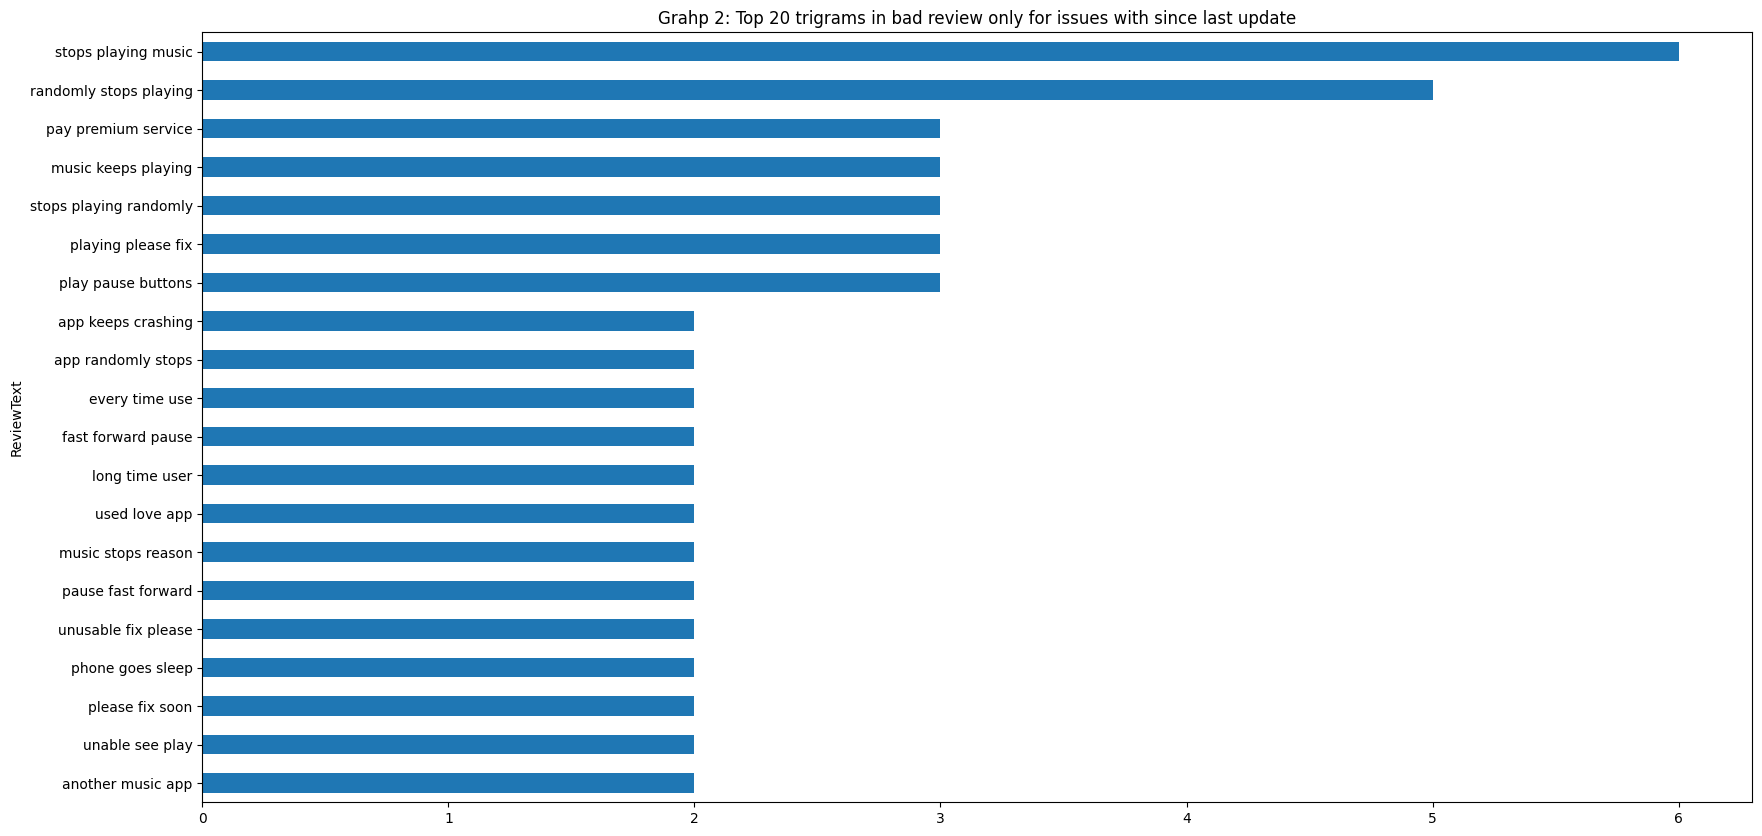

In [43]:
common_words = top_n_ngram(bad_reviews['review_string'], 20,3, stopwordnews)
df_sinceLastUpdate = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
plt.figure(figsize =(20,10))
df_sinceLastUpdate.groupby('ReviewText').sum()['count'].sort_values(ascending=True).plot(
kind='barh', title='Grahp 2: Top 20 trigrams in bad review only for issues with since last update')

From result above, we could see that majority problems associated with 'since last update' are how the app suddenly stop playing music, app keeps crashing, and randomly playing the music on background.

**Observing the occurance of "Since last update" issues**

Now we know what kind of probles our users have encountered, but since Spotify has so many updates throughout the year, we want to point out which update period generating all of these issue being mentioned by our users

In order to do so, we want to modify the DataFrame column of 'Date' into category of 'Month'


In [44]:
music_review2.head(3)

,Time_submitted,Review,Rating,Total_thumbsup,Reply,Rating_Category,review_token,review_string,Dates,Time,day,month,year
258,2022-07-08 23:06:48,"since the last update, my spotify has been pau...",1,2,NaN,Bad,"[since, last, update, spotify, pausing, freque...",since last update spotify pausing frequently f...,2022-07-08,23:06:48,8,7,2022
597,2022-07-08 07:53:20,super buggy since the last update: doesnt show...,1,0,NaN,Bad,"[super, buggy, since, last, update, doesnt, sh...",super buggy since last update doesnt show what...,2022-07-08,07:53:20,8,7,2022
906,2022-07-07 15:31:14,i've had spotify paid subscription for years a...,5,0,NaN,Good,"[spotify, paid, subscription, years, love, app...",spotify paid subscription years love app ever ...,2022-07-07,15:31:14,7,7,2022


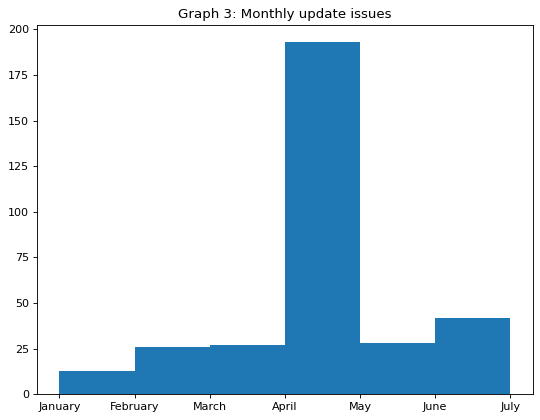

In [45]:
fig = figure(figsize=(8, 6), dpi=80)
plt.hist(music_review2['month'], bins=6, rwidth = 10)
plt.xticks(ticks = [1,2,3,4,5,6,7],labels =['January','February','March','April','May','June','July'])
plt.title("Graph 3: Monthly update issues")
plt.show()

From histogram above, now we know that April and June have the most bad reviews addressing about the 'since last update' issues which might could help the developer to examine more specifically about how the April and June update went and if there's anything could be improved or fixed about it

### Report

**Problem Statement**: The Spotify team wants to understand and improve the customer experience based on reviews (feedback) provided by their customers.

**Challenges**:
1. Difficult to segment positive adjectives like good, great based on the ratings since they are used for both positive and negative review.

1. Manual configuration of stopwords, based on the results priorly derived.

**Solution**: Based on the frequency of the words visualised in the word cloud, positive adjectives like good and great have also been used to describe the negative reviews. Context of these negative review portrayed in Graph 1 shows that majority of the issues with the app are based on update, User Interface (eg: Random pausing of songs) and app crash.
Further investigation revealed that updates released during the months of April and June caused major problem as visualised by the Graph 3. Contextual understanding of these updates during these months surfaced the problems which involved app crashing as the main bug of the update provided in Graph 2. 

**Recommendation**: To improve and fix the bugs causing app crash and improve the UI experience with new update.
